In [1]:
# C2P modules
from metric import metric
from hybrid_eos import hybrid_eos
from c2p import *

# Numpy and matplotlib
import numpy as np 
import matplotlib.pyplot as plt 

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter



# Scikit-learn and Time
from sklearn.model_selection import train_test_split
import time

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available! PyTorch can use GPU.")
else:
    print(f"CUDA is not available. PyTorch will use CPU.")

# Check the current device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch is using device: {device}")

# Check how many GPUs are available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# Print detailed info about each GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
    print(f"  Memory Cached: {torch.cuda.memory_reserved(i)} bytes")

CUDA is available! PyTorch can use GPU.
PyTorch is using device: cuda
Number of GPUs available: 1
GPU 0: AMD Instinct MI210
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


## Try setting up a NN
We will try to set up a Informed Neural Net to solve the inverse c2p problem in numerical relativity. This network is based on the standard 1-D hydro inverter that solves for z (a function of the enthalpy). This algorithm is chosen since it only really depends on three inputs: tau and the norm of S normalised by the conserved density and the density itself.

In [3]:
class c2p_NN(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, hidden_layers=3, neurons=50, dropout_rate=0.1):
        super(c2p_NN, self).__init__()
        
        # Default to cuda if available
        self.device = device

        # Define layers
        layers = []
        layers.append(nn.Linear(input_dim, neurons))  # Input layer
        layers.append(nn.ReLU())  # Activation
        for _ in range(hidden_layers):
            layers.append(nn.Linear(neurons, neurons))  # Hidden layers
            layers.append(nn.ReLU())  # Activation
            layers.append(nn.BatchNorm1d(neurons))
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(neurons, output_dim))  # Output layer

        # Combine layers into a sequential model
        self.network = nn.Sequential(*layers)
        
        # Move the model to the desired device
        self.to(self.device)

    def forward(self, x):
        # Ensure the input tensor is moved to the correct device
        x = x.to(self.device)
        return self.network(x)


class c2p_NNSmall(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, dropout_rate=0.1, device='cuda'):
        super(c2p_NNSmall, self).__init__()
        
        # Default to cuda if available
        self.device = device

        # Define layers
        layers = []
        
        # Input layer to first hidden layer
        layers.append(nn.Linear(input_dim, 600))  # Input layer (3 nodes) to hidden layer (600 nodes)
        layers.append(nn.ReLU())  # Activation for the first hidden layer
        
        # Hidden layer 1 to hidden layer 2
        layers.append(nn.Linear(600, 200))  # Hidden layer 1 (600 nodes) to hidden layer 2 (200 nodes)
        layers.append(nn.ReLU())  # Activation for the second hidden layer

        # Output layer
        layers.append(nn.Linear(200, output_dim))  # Hidden layer 2 (200 nodes) to output layer (1 node)

        # Optionally, add Dropout (with the specified dropout rate)
        if dropout_rate > 0:
            layers.append(nn.Dropout(dropout_rate))  # Dropout regularization

        # Combine layers into a sequential model
        self.network = nn.Sequential(*layers)
        
        # Move the model to the desired device (GPU or CPU)
        self.to(self.device)

    def forward(self, x):
        # Ensure the input tensor is moved to the correct device
        x = x.to(self.device)
        return self.network(x)

    def save(self, path):
        scripted_model = torch.jit.script(self)
        torch.jit.save(scripted_model, path)

    def load(self, path):
        self.load_state_dict(torch.load(path))


In [4]:
def get_initial_state(metric,eos,rho,T,vel):
    # First compute primitives 
    press,eps = eos.press_eps__temp_rho(T,rho)
    p = prims(rho,vel,eps,press)
    # Then conservatives 
    cons = p2c(metric,p)
    # Finally the actual inputs can be computed
    q = cons.tau# / cons.dens
    r = np.sqrt(metric.square_norm_lower(cons.stilde))# / cons.dens
    t = cons.dens / metric.sqrtg
    zeta = np.zeros(t.shape)
    for i in range(len(zeta)):
        cc = conservs(cons.dens[i],cons.stilde[i,:],cons.tau[i])
        #  Finally invert to find the correct answer
        inverter = c2p(metric,cc,eos)
        _ ,zeta[i] = inverter.invert()

    # return np.stack((t,q,r),axis=1), zeta Did Carlo train the wrong dataset?
    return np.stack((t,q,r),axis=1), press

def setup_initial_state(metric,eos,N,lrhomin,lrhomax,ltempmin,ltempmax,Wmin,Wmax):
    """
    Setup a given number of random inputs for the PINN
    metric:   The metric tensor
    eos:      The equation of state
    N:        Number of inputs
    lrhomin:  Lower bound for log10(rho)
    lrhomax:  Upper bound for log10(rho)
    ltempmin: Lower bound for log10(temp)
    ltempmax: Upper bound for log10(temp)
    Wmin:     Lower bound for W lorentz
    Wmax:     Upper bound for W lorentz
    Inputs are computed as N random sets of primitives within the specified 
    bounds. The output of this function is the torch tensor to be fed to the 
    NN as well as the correct output to expect (z).
    """ 
    # Step 1: get velocities
    W = np.random.uniform(Wmin,Wmax,N)#np.ones(N)*1.1#np.random.uniform(1,1.1,N)#np.ones(N)*(1/np.sqrt(1-0.1**2))#np.random.uniform(Wmin,Wmax,N)
    vel = np.ones((N,3)) #np.random.uniform(-1, 1, (N,3) )
    #vel[:,0] = 0.1 
    
    # rescale by desired Lorentz factor and normalize
    vnorm = np.sqrt((W**2-1)/metric.squareUbatched(vel))/W
    
    vel *= vnorm[:,np.newaxis]
    
    rho = 10**np.random.uniform(lrhomin,lrhomax,N)
    
    T = 10**np.random.uniform(ltempmin,ltempmax,N)
    
    return get_initial_state(metric,eos,rho,T,vel)    
    

In [5]:
eta = metric(
np.eye(3), np.zeros(3), 1
)
eos = hybrid_eos(100,2,1.8)

In [6]:
# Setup the initial state
lrhomin = -12
lrhomax = -2.8

ltempmin = -1 
ltempmax = 2.3

Wmin = 1
Wmax = 2 

N = 1<<15
inputs_np,outputs_np = setup_initial_state(eta,eos,N,lrhomin,lrhomax,ltempmin,ltempmax,Wmin,Wmax)

In [7]:
# Setup the initial state
lrhomin = -12
lrhomax = -2.8

ltempmin = -1 
ltempmax = 2.3

Wmin = 1
Wmax = 2 

N = 1<<16
inputs_np,outputs_np = setup_initial_state(eta,eos,N,lrhomin,lrhomax,ltempmin,ltempmax,Wmin,Wmax)

inputs = torch.from_numpy(inputs_np).float()
outputs = torch.from_numpy(outputs_np).float()

in_mean = inputs.mean(axis=0)
out_mean = outputs.mean(axis=0)

in_std = inputs.std(axis=0)
out_std = outputs.std(axis=0)

print(f"Input: size {N} mean {in_mean.detach().numpy()} std {in_std.detach().numpy()}")

inputs = (inputs-in_mean)/in_std
outputs = (outputs-out_mean)/out_std


# Split the data into train, validation, and test sets (e.g., 70% train, 15% validation, 15% test)
train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(
    inputs, outputs, test_size=0.3, random_state=42
)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(
    temp_inputs, temp_outputs, test_size=0.5, random_state=42
)

# Create DataLoaders for each set
batch_size = 64

train_dataset = TensorDataset(train_inputs, train_outputs)
val_dataset = TensorDataset(val_inputs, val_outputs)
test_dataset = TensorDataset(test_inputs, test_outputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check if CUDA is available and set the device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model, optimizer, and scheduler
#model = c2p_NN(input_dim=3, output_dim=1, hidden_layers=4, neurons=300).to(device)
model = c2p_NNSmall(input_dim=3, output_dim=1,device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)#, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training loop with validation
num_epochs = 100
err_train = []
err_val = []

# Early stopping parameters
patience = 20 # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
epochs_without_improvement = 0  # Counter for epochs without improvement

print("Starting training loop...")
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_inputs, batch_labels in train_loader:
        # Move data to device
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        predictions = model(batch_inputs)
        loss = torch.mean((predictions - batch_labels) ** 2) + 150*torch.relu(-(predictions * out_std + out_mean)).sum()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # Print detailed info about each GPU

    train_loss /= len(train_loader)
    err_train.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_inputs_batch, val_labels_batch in val_loader:
            # Move validation data to device
            val_inputs_batch, val_labels_batch = val_inputs_batch.to(device), val_labels_batch.to(device)

            val_predictions = model(val_inputs_batch)
            val_loss += torch.mean((val_predictions - val_labels_batch) ** 2).item() + 150*torch.relu(-(predictions * out_std + out_mean)).sum()

    val_loss /= len(val_loader)
    err_val.append(val_loss)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset the counter if validation loss improves
    else:
        epochs_without_improvement += 1

    # If validation loss hasn't improved for 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

    # Print progress every 10 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Test the model
model.eval()
test_loss = 0
with torch.no_grad():
    for test_inputs_batch, test_labels_batch in test_loader:
        test_inputs_batch, test_labels_batch = test_inputs_batch.to(device), test_labels_batch.to(device)
        test_predictions = model(test_inputs_batch)
        test_loss += torch.mean(torch.abs(test_predictions - test_labels_batch)).item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.6f}")

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"Time taken: {elapsed_time:.4f} seconds")

Input: size 65536 mean [0.00011559 0.00897733 0.00829728] std [0.00036248 0.06088575 0.05776338]
Using device: cuda
Starting training loop...
Epoch 0, Train Loss: 1.0018233172517566, Val Loss: 1.1131327152252197
Epoch 5, Train Loss: 0.9756447586258211, Val Loss: 1.1126497983932495
Epoch 10, Train Loss: 0.975276977930483, Val Loss: 1.1127017736434937
Epoch 15, Train Loss: 0.9751837033819994, Val Loss: 1.1124011278152466
Epoch 20, Train Loss: 0.9749597428961445, Val Loss: 1.112350583076477
Epoch 25, Train Loss: 0.9749098343221339, Val Loss: 1.1126786470413208
Epoch 30, Train Loss: 0.9763418761454783, Val Loss: 1.1124728918075562
Early stopping triggered after 34 epochs.
Test Loss: 0.291037
Time taken: 82.1959 seconds


In [8]:
# Create a SummaryWriter for TensorBoard
writer = SummaryWriter('runs/model_visualization')

# Create a dummy input tensor
dummy_input = torch.randn(1, 3)  # Input with 3 features

# Add the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the writer
writer.close()

In [60]:
test,test_out = setup_initial_state(eta,eos,1000,lrhomin,lrhomax,ltempmin,ltempmax,Wmin,Wmax)
test_dataset = TensorDataset(test, test_out)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True).to(device)
model.eval()
z = model(torch.from_numpy(test).float())
print(z - test_out)

Inversion successful


TypeError: 'int' object is not callable

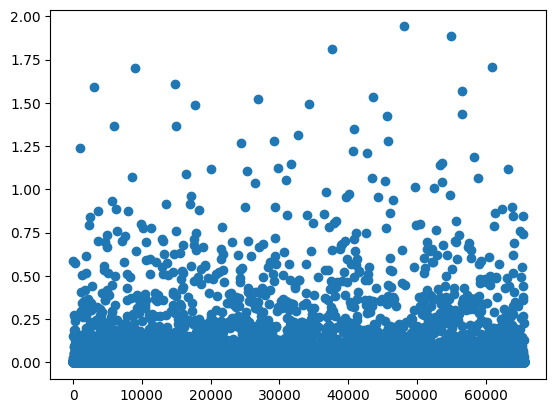

In [9]:
plt.scatter(np.arange(inputs_np[:,0].shape[0]),inputs_np[:,2])

65536


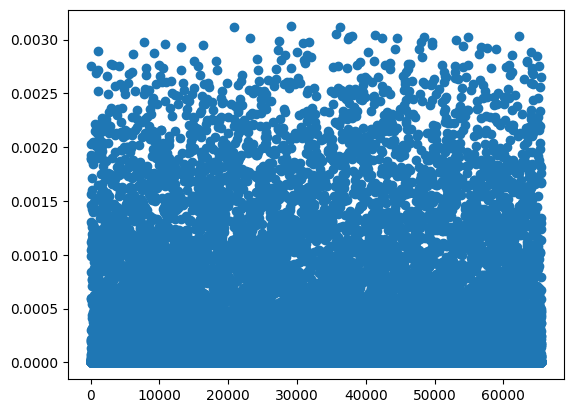

In [10]:
print(inputs_np[:,0].shape[0])
plt.scatter(np.arange(inputs_np[:,0].shape[0]),inputs_np[:,0])

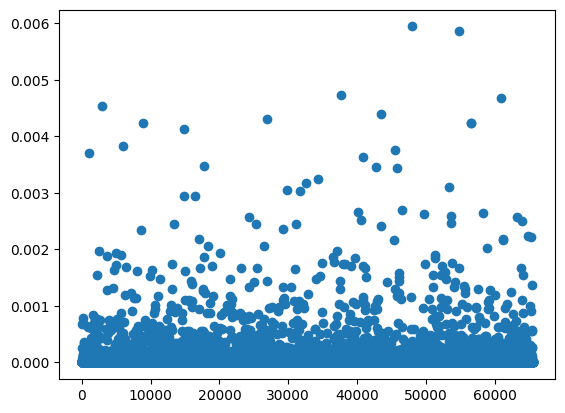

In [11]:
plt.scatter(np.arange(inputs_np[:,0].shape[0]),inputs_np[:,1]*inputs_np[:,0])

In [12]:
1<<20

1048576

In [13]:
train_dataset.tensors[1]

tensor([4.1817e-10, 1.1138e-02, 1.3917e-05,  ..., 1.6672e-10, 1.2135e-04,
        1.1152e-10])